In [1]:
import itertools
import numpy as np 
import sys
sys.path.append('../')
from SetupTransitionTable import SetupDeterministicTransitionByStateSet
from SetupRewardTable import SetupStateActionRewardWithUserSpecifiedCosts
from visualizations import *
from ValueIteration import BoltzmannValueIteration

# Setup Belief Dynamics

In [2]:
class SetupBeliefTransition(object):
    def __init__(self, positionSet, beliefSet, actionSet, observationPositionSet):
        self.positionSet = positionSet
        self.beliefSet = beliefSet
        self.actionSet = actionSet
        self.observationPositionSet = observationPositionSet

    def __call__(self, getNewBelief):
        beliefTransition = {(position, belief): self.getActionNewBeliefTransition(position, belief, getNewBelief) \
         for position in self.positionSet \
         for belief in self.beliefSet}
        return(beliefTransition)
    
    def getActionNewBeliefTransition(self, position, belief, getNewBelief):
        actionTransition = {}
        for action in self.actionSet:
            newPosition = self.updatePosition(position, action)
            newBeliefDictionary = getNewBelief(newPosition, belief, action, self.observationPositionSet)
            actionTransition[action] = newBeliefDictionary
        return(actionTransition)
        
    def updatePosition(self, position, action):
        potentialNextState = tuple([position[i] + action[i] for i in range(len(position))])
        if potentialNextState in self.positionSet:
            return(potentialNextState)
        return(position) 

In [3]:
def updateBelief(position, belief, action, observationLocations):
    truck1Observed, truck2Observed = [(position in observationSet) for observationSet in observationLocations]
    
    bothTruckWorlds = list(set([t for t in itertools.permutations([1,0,0,0,0,0], 6)]))
    truck1worlds = [(.5,.5,0,0,0,0),(0,0,.5,.5,0,0,),(0,0,0,0,.5,.5)]
    truck2worlds =  [(0,0,.5,0,.5,0),(.5,0,0,0,0,.5),(0,.5,0,.5,0,0)]
    
    if belief in truck1worlds and truck2Observed:
        newBeliefs = [[b1*b2 for b1, b2 in zip(belief1, belief2)] \
                              for belief1, belief2 in itertools.product([belief], truck2worlds)]
        #print("Belief t1: ", belief, "new position: ", position, "action: ", action, "new beliefs: ", newBeliefs,"\n")
        
    elif belief in truck2worlds and truck1Observed:
        newBeliefs = [[b1*b2 for b1, b2 in zip(belief1, belief2)] \
                              for belief1, belief2 in itertools.product([belief], truck1worlds)]
        #print("Belief t2: ", belief, "new position: ", position, "action: ",action,"new beliefs: ", newBeliefs,"\n")
    elif belief == (1/6,1/6,1/6,1/6,1/6,1/6):
        #print("Position: ", position, "Belief agnostic: ", belief, "\n")
        t1 = truck1worlds if truck1Observed else [belief]
        t2 = truck2worlds if truck2Observed else [belief]
        newBeliefs = [[b1*b2 for b1, b2 in zip(belief1, belief2)] \
                              for belief1, belief2 in itertools.product(t1, t2)]
        #print("New Beliefs: ", newBeliefs, "\n")
    else:
        #print("Position", position, "No change: ", belief, "\n")
        newBeliefs = [belief]
    
    normalizedNewBeliefs = [[worldProb / sum(belief) for worldProb in belief] for belief in newBeliefs if sum(belief)>0]
    beliefsAsSet = set(tuple(x) for x in normalizedNewBeliefs)

    nextBeliefs = [list(x) for x in beliefsAsSet]
    probBelief = 1/len(nextBeliefs)

    newBeliefDictionary = {(position, tuple(belief)): probBelief for belief in nextBeliefs}
    return(newBeliefDictionary)

In [4]:
    #newBeliefs = []
    #for belief1, belief2 in itertools.product(truck1worlds, truck2worlds):
    #    potentialNewBelief = [b1*b2*b for b1, b2, b in zip(belief1, belief2, belief)]
    #    if sum(potentialNewBelief) !=0:
    #        newBeliefs.append(potentialNewBelief)
        #if sum(potentialNewBelief) == 0 and truck1Observed:
        #    newBeliefs.extend([(1,1,0,0,0,0),(0,0,1,1,0,0,),(0,0,0,0,1,1)])
        #if sum(potentialNewBelief) == 0 and truck2Observed:
        #    newBeliefs.extend([(0,0,1,0,1,0),(1,0,0,0,0,1),(0,1,0,1,0,0)])

In [5]:
class SetupRewardBeliefTable(object):
    def __init__(self, positionSet, beliefSet, actionSet):
        self.positionSet = positionSet
        self.beliefSet = beliefSet
        self.actionSet = actionSet
        
    def __call__(self, beliefTransition, worldRewardList):
        rewardTable = {(position, belief): {action: {nextState: self.getRewardBelief(position, belief, action, worldRewardList) \
                                                         for nextState in beliefTransition[(position, belief)][action].keys()}\
                             for action in self.actionSet} \
         for position in self.positionSet \
         for belief in self.beliefSet}
        return(rewardTable)
    
    def getRewardBelief(self, position, belief, action, worldRewards):
        #print("Belief Reward Called", [reward for reward, probWorld in zip(worldRewards, belief)])
        rewardBelief = sum([reward[position][action]*probWorld for reward, probWorld in zip(worldRewards, belief)])
        return(rewardBelief)


# Environment Setup

In [6]:
# Actions correspond to E, N, W, S, Stay respectively
allActions = [(1,0), (0,1), (-1,0), (0,-1), (0,0)]

#all location states in grid
gridWidth = 5
gridHeight = 4
gridSet = set(itertools.product(range(gridWidth), range(gridHeight)))

#set of states to remove from each environment
barriersC = {(2,2), (3,2), (4,2)}

#final environment state sets
stateSetC = list(gridSet.difference(barriersC))

#goal locations
goalTruck1 = (0,0)
goalTruck2 = (4,3)

#observation positions
observeTruck1 = [(0, 0),(1, 3),(3, 0),(0, 2),(2, 1),(1, 0),(0, 3),(4, 0),(0, 1),(1, 2),(3, 1),(2, 0),(4, 1),(1, 1)]
observeTruck2 = [(0,3), (1,3), (2,3), (3,3), (4,3)] 

#possible beliefs
beliefSet= list(set([t for t in itertools.permutations([1,0,0,0,0,0], 6)]))
otherHypotheses = [(.5,.5,0,0,0,0),(0,0,.5,.5,0,0),(0,0,0,0,.5,.5),(0,0,.5,0,0.5,0),(.5,0,0,0,0,0.5),(0,.5,0,.5,0,0),(1/6,1/6,1/6,1/6,1/6,1/6)]
beliefSet.extend(otherHypotheses)

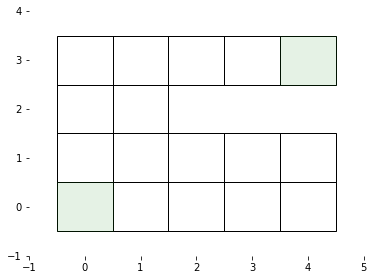

In [7]:
visualizeEnvironmentByState(states = stateSetC, goalStates = [goalTruck1, goalTruck2])

In [8]:
getTransition = SetupDeterministicTransitionByStateSet(stateSetC, allActions)
positionTransition = getTransition()

## Belief Transition Setup

In [9]:
getTransitionC = SetupBeliefTransition(stateSetC, beliefSet, allActions, [observeTruck1, observeTruck2])
beliefTransition_EnvC = getTransitionC(updateBelief)

In [10]:
[''.join(preference) for preference in itertools.permutations("KLM",2)]

['KL', 'KM', 'LK', 'LM', 'MK', 'ML']

In [11]:
viewDictionaryStructure(beliefTransition_EnvC, 't')

state: ((0, 0), (0, 0, 0, 0, 1, 0))
	action: (1, 0)
		next state: ((1, 0), (0.0, 0.0, 0.0, 0.0, 1.0, 0.0))
			probability: 1.0
	action: (0, 1)
		next state: ((0, 1), (0.0, 0.0, 0.0, 0.0, 1.0, 0.0))
			probability: 1.0
	action: (-1, 0)
		next state: ((0, 0), (0.0, 0.0, 0.0, 0.0, 1.0, 0.0))
			probability: 1.0
	action: (0, -1)
		next state: ((0, 0), (0.0, 0.0, 0.0, 0.0, 1.0, 0.0))
			probability: 1.0
	action: (0, 0)
		next state: ((0, 0), (0.0, 0.0, 0.0, 0.0, 1.0, 0.0))
			probability: 1.0
state: ((0, 0), (1, 0, 0, 0, 0, 0))
	action: (1, 0)
		next state: ((1, 0), (1.0, 0.0, 0.0, 0.0, 0.0, 0.0))
			probability: 1.0
	action: (0, 1)
		next state: ((0, 1), (1.0, 0.0, 0.0, 0.0, 0.0, 0.0))
			probability: 1.0
	action: (-1, 0)
		next state: ((0, 0), (1.0, 0.0, 0.0, 0.0, 0.0, 0.0))
			probability: 1.0
	action: (0, -1)
		next state: ((0, 0), (1.0, 0.0, 0.0, 0.0, 0.0, 0.0))
			probability: 1.0
	action: (0, 0)
		next state: ((0, 0), (1.0, 0.0, 0.0, 0.0, 0.0, 0.0))
			probability: 1.0
state: ((0, 0)

			probability: 0.3333333333333333
		next state: ((4, 0), (0.5, 0.5, 0.0, 0.0, 0.0, 0.0))
			probability: 0.3333333333333333
		next state: ((4, 0), (0.0, 0.0, 0.0, 0.0, 0.5, 0.5))
			probability: 0.3333333333333333
state: ((0, 1), (0, 0, 0, 0, 1, 0))
	action: (1, 0)
		next state: ((1, 1), (0.0, 0.0, 0.0, 0.0, 1.0, 0.0))
			probability: 1.0
	action: (0, 1)
		next state: ((0, 2), (0.0, 0.0, 0.0, 0.0, 1.0, 0.0))
			probability: 1.0
	action: (-1, 0)
		next state: ((0, 1), (0.0, 0.0, 0.0, 0.0, 1.0, 0.0))
			probability: 1.0
	action: (0, -1)
		next state: ((0, 0), (0.0, 0.0, 0.0, 0.0, 1.0, 0.0))
			probability: 1.0
	action: (0, 0)
		next state: ((0, 1), (0.0, 0.0, 0.0, 0.0, 1.0, 0.0))
			probability: 1.0
state: ((0, 1), (1, 0, 0, 0, 0, 0))
	action: (1, 0)
		next state: ((1, 1), (1.0, 0.0, 0.0, 0.0, 0.0, 0.0))
			probability: 1.0
	action: (0, 1)
		next state: ((0, 2), (1.0, 0.0, 0.0, 0.0, 0.0, 0.0))
			probability: 1.0
	action: (-1, 0)
		next state: ((0, 1), (1.0, 0.0, 0.0, 0.0, 0.0, 0.0))
		

### Example transitions

In [12]:
st = ((0,2), beliefSet[6])
a = (0,1)
print(st, "\n", beliefTransition_EnvC[st][a])

((0, 2), (0.5, 0.5, 0, 0, 0, 0)) 
 {((0, 3), (0.0, 1.0, 0.0, 0.0, 0.0, 0.0)): 0.5, ((0, 3), (1.0, 0.0, 0.0, 0.0, 0.0, 0.0)): 0.5}


## List of Rewards for Possible Worlds

In [13]:
allWorlds = [''.join(preference) for preference in itertools.permutations("KLM",2)]
allPreferences = [''.join(preference) for preference in itertools.permutations("KLM",3)]

In [14]:
def constructGoalStateRewards(truck1truck2,  preference, truckLocations = [(0,0), (4,3)], preferenceRewards = [100, 75, 50]):
    goalPreferences = {location : preferenceRewards[preference.index(truck)] for location, truck in zip(truckLocations, truck1truck2)}
    return(goalPreferences)

In [15]:
getRewardC = SetupStateActionRewardWithUserSpecifiedCosts(positionTransition, allActions, [goalTruck1,goalTruck2])
rewards_EnvC_PrefMLK = [getRewardC(constructGoalStateRewards(world, 'MLK')) for world in allWorlds]

In [16]:
getRewardBeliefs = SetupRewardBeliefTable(stateSetC, beliefSet, allActions)
beliefReward_EnvC_MLK = getRewardBeliefs(beliefTransition_EnvC, rewards_EnvC_PrefMLK)

### Example Rewards

In [17]:
viewDictionaryStructure(beliefReward_EnvC_MLK, 'r')

state: ((0, 0), (0, 0, 0, 0, 1, 0))
	action: (1, 0)
		next state: ((1, 0), (0.0, 0.0, 0.0, 0.0, 1.0, 0.0))
			reward: -1.0
	action: (0, 1)
		next state: ((0, 1), (0.0, 0.0, 0.0, 0.0, 1.0, 0.0))
			reward: -1.0
	action: (-1, 0)
		next state: ((0, 0), (0.0, 0.0, 0.0, 0.0, 1.0, 0.0))
			reward: 99.0
	action: (0, -1)
		next state: ((0, 0), (0.0, 0.0, 0.0, 0.0, 1.0, 0.0))
			reward: 99.0
	action: (0, 0)
		next state: ((0, 0), (0.0, 0.0, 0.0, 0.0, 1.0, 0.0))
			reward: 99.9
state: ((0, 0), (1, 0, 0, 0, 0, 0))
	action: (1, 0)
		next state: ((1, 0), (1.0, 0.0, 0.0, 0.0, 0.0, 0.0))
			reward: -1.0
	action: (0, 1)
		next state: ((0, 1), (1.0, 0.0, 0.0, 0.0, 0.0, 0.0))
			reward: -1.0
	action: (-1, 0)
		next state: ((0, 0), (1.0, 0.0, 0.0, 0.0, 0.0, 0.0))
			reward: 49.0
	action: (0, -1)
		next state: ((0, 0), (1.0, 0.0, 0.0, 0.0, 0.0, 0.0))
			reward: 49.0
	action: (0, 0)
		next state: ((0, 0), (1.0, 0.0, 0.0, 0.0, 0.0, 0.0))
			reward: 49.9
state: ((0, 0), (0, 0, 1, 0, 0, 0))
	action: (1, 0)
		

state: ((0, 3), (1, 0, 0, 0, 0, 0))
	action: (1, 0)
		next state: ((1, 3), (1.0, 0.0, 0.0, 0.0, 0.0, 0.0))
			reward: -1.0
	action: (0, 1)
		next state: ((0, 3), (1.0, 0.0, 0.0, 0.0, 0.0, 0.0))
			reward: -1.0
	action: (-1, 0)
		next state: ((0, 3), (1.0, 0.0, 0.0, 0.0, 0.0, 0.0))
			reward: -1.0
	action: (0, -1)
		next state: ((0, 2), (1.0, 0.0, 0.0, 0.0, 0.0, 0.0))
			reward: -1.0
	action: (0, 0)
		next state: ((0, 3), (1.0, 0.0, 0.0, 0.0, 0.0, 0.0))
			reward: -0.1
state: ((0, 3), (0, 0, 1, 0, 0, 0))
	action: (1, 0)
		next state: ((1, 3), (0.0, 0.0, 1.0, 0.0, 0.0, 0.0))
			reward: -1.0
	action: (0, 1)
		next state: ((0, 3), (0.0, 0.0, 1.0, 0.0, 0.0, 0.0))
			reward: -1.0
	action: (-1, 0)
		next state: ((0, 3), (0.0, 0.0, 1.0, 0.0, 0.0, 0.0))
			reward: -1.0
	action: (0, -1)
		next state: ((0, 2), (0.0, 0.0, 1.0, 0.0, 0.0, 0.0))
			reward: -1.0
	action: (0, 0)
		next state: ((0, 3), (0.0, 0.0, 1.0, 0.0, 0.0, 0.0))
			reward: -0.1
state: ((0, 3), (0, 1, 0, 0, 0, 0))
	action: (1, 0)
		

			reward: -1.0
	action: (0, -1)
		next state: ((1, 1), (0.0, 0.0, 0.0, 0.0, 1.0, 0.0))
			reward: -1.0
	action: (0, 0)
		next state: ((1, 2), (0.0, 0.0, 0.0, 0.0, 1.0, 0.0))
			reward: -0.1
state: ((1, 2), (1, 0, 0, 0, 0, 0))
	action: (1, 0)
		next state: ((1, 2), (1.0, 0.0, 0.0, 0.0, 0.0, 0.0))
			reward: -1.0
	action: (0, 1)
		next state: ((1, 3), (1.0, 0.0, 0.0, 0.0, 0.0, 0.0))
			reward: -1.0
	action: (-1, 0)
		next state: ((0, 2), (1.0, 0.0, 0.0, 0.0, 0.0, 0.0))
			reward: -1.0
	action: (0, -1)
		next state: ((1, 1), (1.0, 0.0, 0.0, 0.0, 0.0, 0.0))
			reward: -1.0
	action: (0, 0)
		next state: ((1, 2), (1.0, 0.0, 0.0, 0.0, 0.0, 0.0))
			reward: -0.1
state: ((1, 2), (0, 0, 1, 0, 0, 0))
	action: (1, 0)
		next state: ((1, 2), (0.0, 0.0, 1.0, 0.0, 0.0, 0.0))
			reward: -1.0
	action: (0, 1)
		next state: ((1, 3), (0.0, 0.0, 1.0, 0.0, 0.0, 0.0))
			reward: -1.0
	action: (-1, 0)
		next state: ((0, 2), (0.0, 0.0, 1.0, 0.0, 0.0, 0.0))
			reward: -1.0
	action: (0, -1)
		next state: ((1, 1)

	action: (0, 1)
		next state: ((1, 2), (1.0, 0.0, 0.0, 0.0, 0.0, 0.0))
			reward: -1.0
		next state: ((1, 2), (0.0, 0.0, 0.0, 0.0, 0.0, 1.0))
			reward: -1.0
	action: (-1, 0)
		next state: ((0, 1), (1.0, 0.0, 0.0, 0.0, 0.0, 0.0))
			reward: -1.0
		next state: ((0, 1), (0.0, 0.0, 0.0, 0.0, 0.0, 1.0))
			reward: -1.0
	action: (0, -1)
		next state: ((1, 0), (1.0, 0.0, 0.0, 0.0, 0.0, 0.0))
			reward: -1.0
		next state: ((1, 0), (0.0, 0.0, 0.0, 0.0, 0.0, 1.0))
			reward: -1.0
	action: (0, 0)
		next state: ((1, 1), (1.0, 0.0, 0.0, 0.0, 0.0, 0.0))
			reward: -0.1
		next state: ((1, 1), (0.0, 0.0, 0.0, 0.0, 0.0, 1.0))
			reward: -0.1
state: ((1, 1), (0, 0.5, 0, 0.5, 0, 0))
	action: (1, 0)
		next state: ((2, 1), (0.0, 1.0, 0.0, 0.0, 0.0, 0.0))
			reward: -1.0
		next state: ((2, 1), (0.0, 0.0, 0.0, 1.0, 0.0, 0.0))
			reward: -1.0
	action: (0, 1)
		next state: ((1, 2), (0.0, 1.0, 0.0, 0.0, 0.0, 0.0))
			reward: -1.0
		next state: ((1, 2), (0.0, 0.0, 0.0, 1.0, 0.0, 0.0))
			reward: -1.0
	action: (

In [18]:
worldIndex = 0
state = (4,3)
action= (1,0)
print("world: ", allWorlds[worldIndex], "\n state: ", state, "\n", "reward:", rewards_EnvC_PrefMLK[worldIndex][state][action])

world:  KL 
 state:  (4, 3) 
 reward: 74


## Value Iteration

In [19]:
valueTable = {state:0 for state in beliefTransition_EnvC.keys()}

getPolicy_EnvC_MLK = BoltzmannValueIteration(beliefTransition_EnvC, beliefReward_EnvC_MLK, valueTable, 10e-7, .88, .8)
optimalValuesA, policy_EnvC_MLK = getPolicy_EnvC_MLK()

In [20]:
policy_EnvC_MLK

{((0, 0), (0, 0, 0, 0, 1, 0)): {(1, 0): 2.3623408121013533e-36,
  (0, 1): 2.3623408121013533e-36,
  (-1, 0): 0.2466435992519841,
  (0, -1): 0.2466435992519841,
  (0, 0): 0.5067128014960319},
 ((0, 0), (1, 0, 0, 0, 0, 0)): {(1, 0): 5.56060068907189e-19,
  (0, 1): 5.56060068907189e-19,
  (-1, 0): 0.2466435992519912,
  (0, -1): 0.2466435992519912,
  (0, 0): 0.5067128014960176},
 ((0, 0), (0, 0, 1, 0, 0, 0)): {(1, 0): 1.1461253835245867e-27,
  (0, 1): 1.1461253835245867e-27,
  (-1, 0): 0.24664359925199122,
  (0, -1): 0.24664359925199122,
  (0, 0): 0.5067128014960176},
 ((0, 0), (0, 1, 0, 0, 0, 0)): {(1, 0): 7.208340875948572e-13,
  (0, 1): 7.208340875948572e-13,
  (-1, 0): 0.24664359925163562,
  (0, -1): 0.24664359925163562,
  (0, 0): 0.5067128014952872},
 ((0, 0), (0, 0, 0, 1, 0, 0)): {(1, 0): 1.1461253835245867e-27,
  (0, 1): 1.1461253835245867e-27,
  (-1, 0): 0.24664359925199122,
  (0, -1): 0.24664359925199122,
  (0, 0): 0.5067128014960176},
 ((0, 0), (0, 0, 0, 0, 0, 1)): {(1, 0): 2.362

In [21]:
#preference MLK
allWorlds

['KL', 'KM', 'LK', 'LM', 'MK', 'ML']

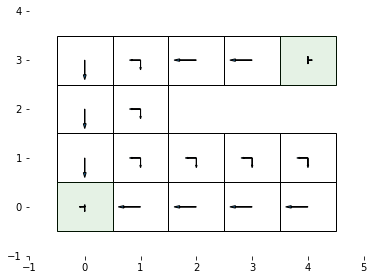

['KL', 'KM', 'LK', 'LM', 'MK', 'ML'] 
 [0, 0, 0, 0, 1, 0] None


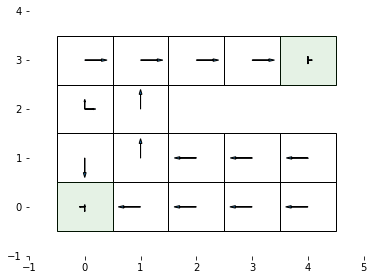

['KL', 'KM', 'LK', 'LM', 'MK', 'ML'] 
 [1, 0, 0, 0, 0, 0] None


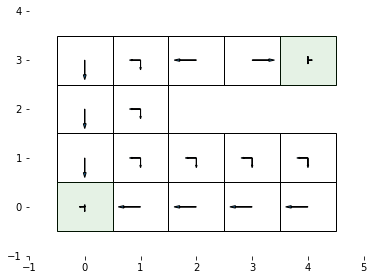

['KL', 'KM', 'LK', 'LM', 'MK', 'ML'] 
 [0, 0, 1, 0, 0, 0] None


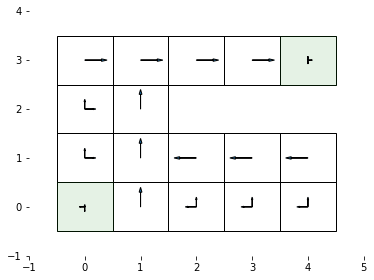

['KL', 'KM', 'LK', 'LM', 'MK', 'ML'] 
 [0, 1, 0, 0, 0, 0] None


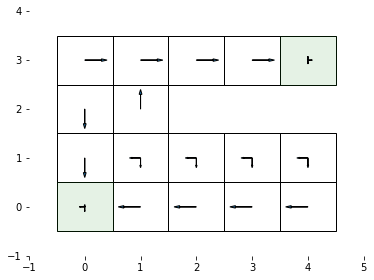

['KL', 'KM', 'LK', 'LM', 'MK', 'ML'] 
 [0, 0, 0, 1, 0, 0] None


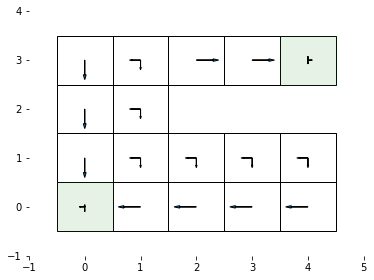

['KL', 'KM', 'LK', 'LM', 'MK', 'ML'] 
 [0, 0, 0, 0, 0, 1] None


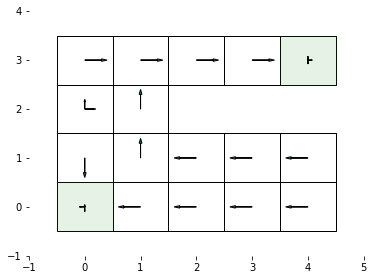

['KL', 'KM', 'LK', 'LM', 'MK', 'ML'] 
 [0.5, 0.5, 0, 0, 0, 0] None


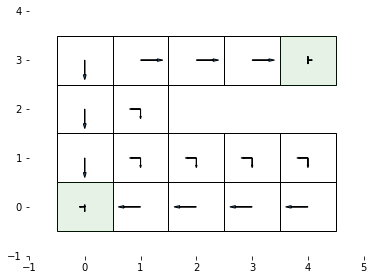

['KL', 'KM', 'LK', 'LM', 'MK', 'ML'] 
 [0, 0, 0.5, 0.5, 0, 0] None


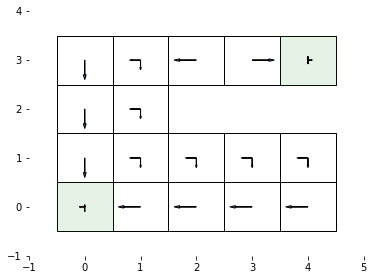

['KL', 'KM', 'LK', 'LM', 'MK', 'ML'] 
 [0, 0, 0, 0, 0.5, 0.5] None


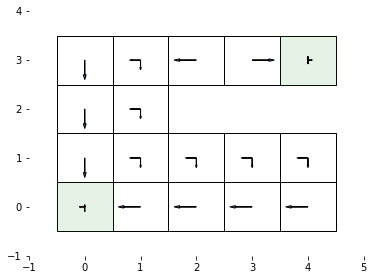

['KL', 'KM', 'LK', 'LM', 'MK', 'ML'] 
 [0, 0, 0.5, 0, 0.5, 0] None


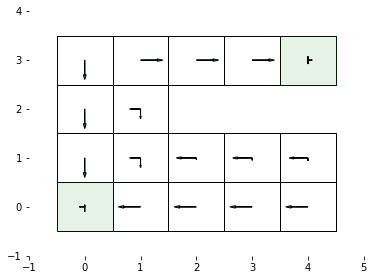

['KL', 'KM', 'LK', 'LM', 'MK', 'ML'] 
 [0.5, 0, 0, 0, 0, 0.5] None


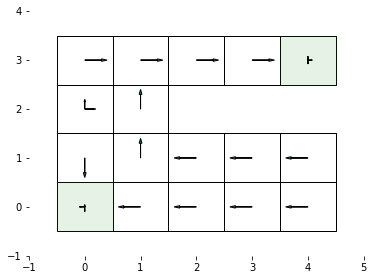

['KL', 'KM', 'LK', 'LM', 'MK', 'ML'] 
 [0, 0.5, 0, 0.5, 0, 0] None


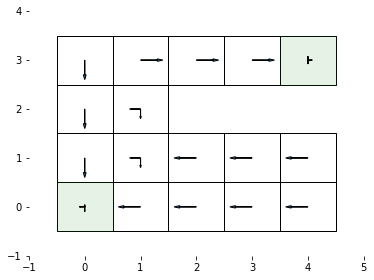

['KL', 'KM', 'LK', 'LM', 'MK', 'ML'] 
 [0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666] None


[None, None, None, None, None, None, None, None, None, None, None, None, None]

In [22]:
[print(allWorlds,"\n",list(b), visualizePolicyOfBeliefByState(stateSetC, policy_EnvC_MLK, b, goalStates = [goalTruck1, goalTruck2])) for b in beliefSet]

In [23]:
def samplePathToGoal(position, belief, policy, transition, goals):
    trajectory = [(position, belief)]

    while position not in goals:
        #take action probabilisitically
        actions = list(policy[(position, belief)].keys())
        probOfAction = [policy[(position, belief)][action] for action in actions]
        actionIndex = np.random.choice(len(actions), 1, p = probOfAction)
        sampledAction = actions[int(actionIndex)]
        
        #get new position and belief
        newPosition = list(transition[(position, belief)][sampledAction].keys())[0][0]
        newBelief = list(transition[(position, belief)][sampledAction].keys())[0][1]
        
        #update to new belief/position and add to trajectory
        belief = newBelief
        position = newPosition
        trajectory.append((position, belief))
    return(trajectory)

In [24]:
#np.random.seed(127)
path = samplePathToGoal((4,1), (1/6,1/6,1/6,1/6,1/6,1/6), policy_EnvC_MLK, beliefTransition_EnvC, [(0,0), (4,3)])
positionTrajectory = [pos for pos, belief in path]

In [25]:
print(allWorlds)

['KL', 'KM', 'LK', 'LM', 'MK', 'ML']


In [26]:
path

[((4, 1),
  (0.16666666666666666,
   0.16666666666666666,
   0.16666666666666666,
   0.16666666666666666,
   0.16666666666666666,
   0.16666666666666666)),
 ((3, 1), (0.0, 0.0, 0.5, 0.5, 0.0, 0.0)),
 ((2, 1), (0.0, 0.0, 0.5, 0.5, 0.0, 0.0)),
 ((2, 0), (0.0, 0.0, 0.5, 0.5, 0.0, 0.0)),
 ((1, 0), (0.0, 0.0, 0.5, 0.5, 0.0, 0.0)),
 ((0, 0), (0.0, 0.0, 0.5, 0.5, 0.0, 0.0))]